In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#script-specific imports
import os
import scrublet as scr

In [3]:
adata = scv.read('../data/adata_unprocessed.h5ad')

In [4]:
timepoint_fix = {'D3':'D3', 'D4':'D4', 'D5':'D5', 
                 'D6':'D6', 'D7':'D7', 'D8':'D8', 
                 '05h':'D3.2', '10h':'D3.4', '15h':'D3.6', '20h':'D3.8'}

adata.obs['timepoint'] = [timepoint_fix[t] for t in adata.obs.timepoint]

adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.obs['label_rate'] = adata.layers['new'].sum(1) / adata.layers['total'].sum(1)

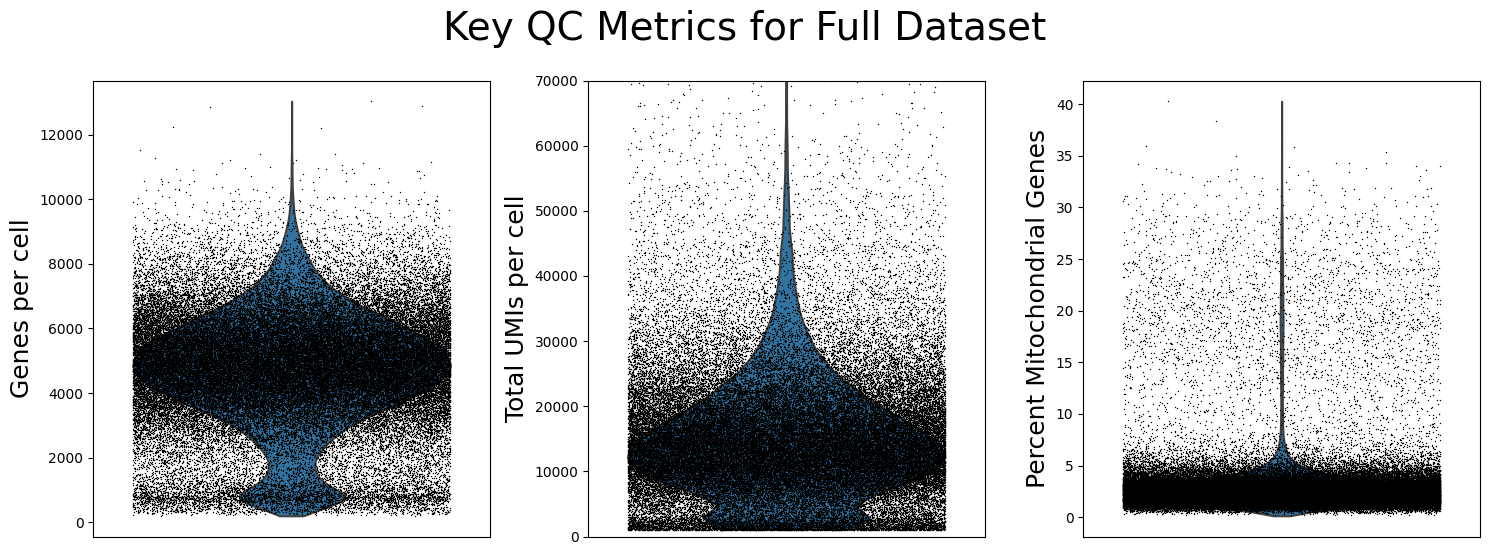

In [5]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
sc.pl.violin(adata, ['n_genes_by_counts'], ax=ax1, show=False, jitter=0.4,stripplot=True)
ax1.set_ylabel("Genes per cell", fontsize=18)
ax1.set_xticks([])
sc.pl.violin(adata, ['total_counts'], ax=ax2, show=False, jitter=0.4,stripplot=True)
ax2.set_ylim((0,70000))
ax2.set_ylabel("Total UMIs per cell", fontsize=18)
ax2.set_xticks([])
sc.pl.violin(adata, ['pct_counts_mt'], ax=ax3, show=False, jitter=0.4,stripplot=True)
ax3.set_ylabel("Percent Mitochondrial Genes", fontsize=18)
ax3.set_xticks([])
plt.tight_layout()
plt.suptitle("Key QC Metrics for Full Dataset", y=1.1, fontsize=28)
plt.show()

In [6]:
subset = adata.copy()

subset=subset[subset.obs.total_counts > np.percentile(adata.obs.total_counts, 10)] ## approx 4k
subset=subset[subset.obs.total_counts < np.percentile(adata.obs.total_counts, 90)] ## approx 25k

subset=subset[subset.obs.n_genes_by_counts > np.percentile(adata.obs.n_genes_by_counts, 10)] ## approx 2k
subset=subset[subset.obs.n_genes_by_counts < np.percentile(adata.obs.n_genes_by_counts, 90)] ## approx 7k

subset=subset[subset.obs.label_rate > np.percentile(adata.obs.label_rate, 10)] ## approx 10%

subset=subset[subset.obs.pct_counts_mt < np.percentile(adata.obs.pct_counts_mt, 90)] ## approx 5%

In [28]:
counts_matrix = subset[subset.obs.rep=='r2'].layers['total'].A

scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 16.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.3%
Elapsed time: 28.6 seconds


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 24.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.4%
Elapsed time: 18.9 seconds


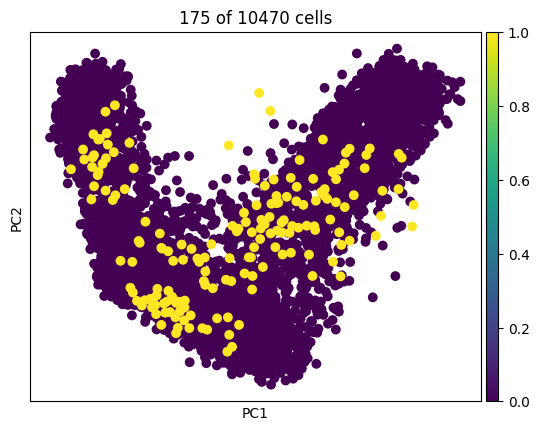

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 16.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.3%
Elapsed time: 18.9 seconds


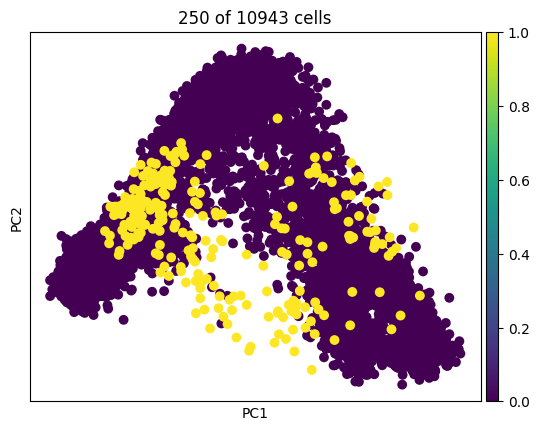

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 35.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 1.5%
Elapsed time: 23.5 seconds


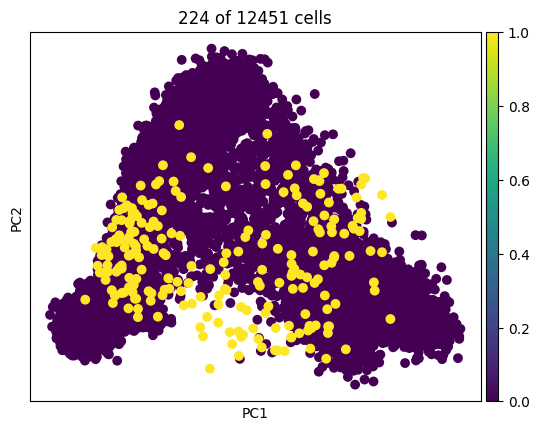

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.4%
Elapsed time: 27.7 seconds


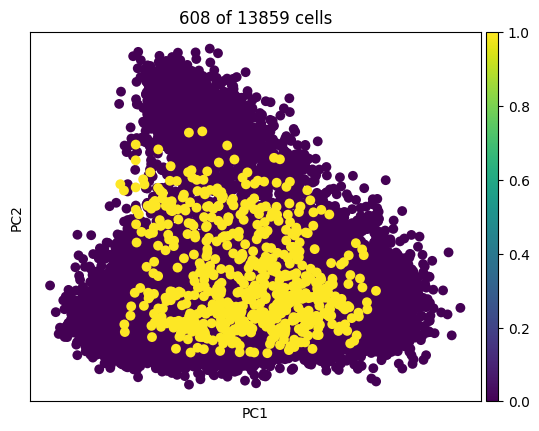

In [67]:
dubs = []
threshold = 0.2
for r in ['r1','r2','r3','r4']:
    sub = subset[subset.obs.rep==r]
    counts_matrix = sub.layers['total'].A
    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    sub.obs['doublet_score'] = doublet_scores
    dubs.append(sub.copy())

    viz = sub.copy()
    sc.pp.normalize_total(viz)
    genes = vt.pp.select_genes(viz)
    viz = viz[:,genes]
    sc.pp.log1p(viz)
    sc.pp.pca(viz)
    viz.obs['doublet'] = (doublet_scores > threshold).astype(int)
    sc.pl.pca(viz, color='doublet', size=200, components='1,2', show=False)
    plt.title(f"{sum(doublet_scores>.2)} of {len(doublet_scores)} cells")
    plt.show()
    


In [70]:
final = ann.concat(dubs)

In [71]:
final.write_h5ad("../data/cellfiltered_adata.h5ad")

est = scv.read('../data/adata_unprocessed_estimate.h5ad')
est = est[final.obs_names,:]
est.write_h5ad("../data/cellfiltered_adata_estimate.h5ad")

spl = scv.read('../data/adata_unprocessed_splicing.h5ad')
spl = spl[final.obs_names,:]
spl.write_h5ad("../data/cellfiltered_adata_splicing.h5ad")